# Time Series Forecasting & Options Pricing on Solana
___________________________________________________________
 - This notebook performs a complete time series analysis on Solana (SOL), including ARIMA forecasting    and Monte Carlo simulations.  
 - The goal is to examine its price behavior, evaluate its suitability for time series modeling, and use  the results to price a European call option.  
 - We use Python and publicly available data from Yahoo Finance for all analysis

<a id="0"></a> <br> 
## Table of Contents

1. [Introduction](#1)  
2. [Data Collection](#2)  
3. [Log Return Calculation](#3)  
4. [Time Series Visualization](#4)  
5. [Stationarity Test (ADF)](#5)  
6. [ARIMA Modeling & Forecast](#6)  
7. [Forecast vs Actual Plot](#7)  
8. [Monte Carlo Simulation](#8)  
9. [European Call Option Pricing](#9)  
10. [Limitations & Reflections](#10)  
11. [References](#11)

### Note on Use of AI Tools

During the preparation of this notebook, AI software tools were used to assist in clarifying code structure, improving explanation clarity, and identifying debugging approaches. All code implementations, analyses, and interpretations were executed and verified independently by the student.  where do i add this in notebook


<a id="1"></a>  
## 1. Introduction

Solana (SOL) is a high-performance blockchain known for fast transaction speeds and low fees. As a cryptocurrency, SOL is also highly volatile and reacts strongly to market sentiment and broader trends like Bitcoin’s price movement.

In this project, we analyze SOL’s historical price behavior using time series techniques. We first visualize and statistically analyze the log returns to understand stationarity and volatility characteristics.

Then, we apply the ARIMA model to forecast near-term prices and simulate possible future paths using Monte Carlo methods. Lastly, we apply financial theory to estimate the value of a European call option written on SOL.

This simulation mimics how professional quant traders model digital assets for portfolio management, trading strategy, and risk evaluation.


<a id="2"></a>  
## 2. Data Collection

We begin by downloading daily historical price data for Solana (SOL) using the `yfinance` library.  
The selected date range (2021–2025) covers multiple market phases — including both bull and bear cycles — to ensure a robust analysis.

This data will be used for return calculations, time series modeling, simulation, and option pricing.

We use the ‘Close’ column to represent daily end-of-day prices.


In [8]:
sol = yf.download('SOL-USD', start='2021-01-01', end='2025-06-25', auto_adjust=False)

print("Data range:", sol.index.min(), "to", sol.index.max())
print("Total rows:", len(sol))
sol.tail()


[*********************100%***********************]  1 of 1 completed

Data range: 2021-01-01 00:00:00 to 2025-06-24 00:00:00
Total rows: 1636


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD
Date,,,,,,
2025-06-20,140.168594,140.168594,148.718903,136.512405,147.072906,4112242022
2025-06-21,135.161011,135.161011,142.499741,132.414246,140.168045,3335622844
2025-06-22,131.615692,131.615692,137.552139,126.826279,135.196350,4990284543
2025-06-23,144.846725,144.846725,146.598495,131.160858,131.615860,5742740781
2025-06-24,145.954529,145.954529,146.589478,142.566681,144.846725,3709899362


### Log Return Calculation

We compute daily log returns from Solana’s closing prices to normalize price changes and prepare for time series modeling. 

Log returns are preferred in financial modeling because they are time-additive and tend to be more normally distributed than simple percentage changes.

The formula used is:  
**log return** = `ln(Pₜ / Pₜ₋₁)`  
where *Pₜ* is today's price and *Pₜ₋₁* is yesterday's price.



In [17]:
import numpy as np

# Extract just the 'Close' prices from the multi-level column
close_prices = sol['Close']['SOL-USD']

# Create a new DataFrame for clean analysis
solana_df = pd.DataFrame()
solana_df['Close'] = close_prices

# Calculate log returns
solana_df['Log_Returns'] = np.log(solana_df['Close'] / solana_df['Close'].shift(1))

# Drop NaN values (first row)
solana_df.dropna(inplace=True)

# Show last few rows
solana_df.tail()




,Close,Log_Returns
Date,,
2025-06-20,140.168594,-0.048073
2025-06-21,135.161011,-0.036379
2025-06-22,131.615692,-0.026580
2025-06-23,144.846725,0.095790
2025-06-24,145.954529,0.007619


<a id="4"></a>  
## 4. Time Series Visualization

Before building any models, it's important to visualize the historical price series.  
This helps identify trends, volatility, structural breaks, or unusual patterns in the data.

In this section, we plot Solana’s daily closing price from 2021 to June 2025.


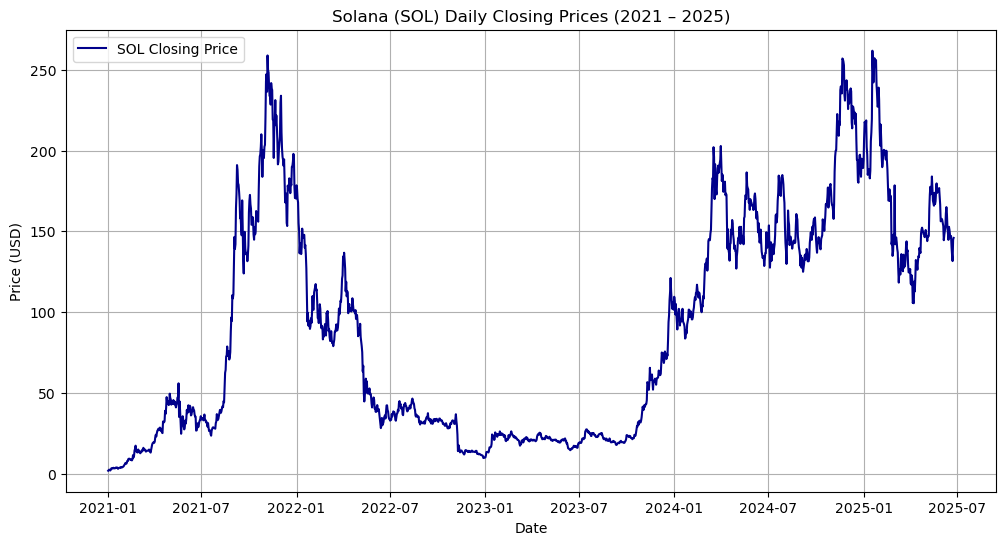

In [18]:
# Plot the historical closing prices of Solana (SOL)
plt.figure(figsize=(12, 6))
plt.plot(solana_df['Close'], label='SOL Closing Price', color='darkblue')
plt.title('Solana (SOL) Daily Closing Prices (2021 – 2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


<a id="5"></a>  
## 5. Stationarity Test (ADF)

To model a time series effectively using ARIMA, the data must be stationary — meaning its statistical properties (mean, variance) do not change over time.

We test the stationarity of Solana’s log return series using the **Augmented Dickey-Fuller (ADF) test**.

- **Null Hypothesis (H₀):** The series is non-stationary (has a unit root)
- **Alternative Hypothesis (H₁):** The series is stationary

We use a p-value threshold of 0.05. If the p-value is below this, we reject H₀ and conclude that the series is stationary.


In [19]:
from statsmodels.tsa.stattools import adfuller

# Run Augmented Dickey-Fuller test on log returns
adf_result = adfuller(solana_df['Log_Returns'])

# Display the results
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Test Statistic: -12.445581840637477
p-value: 3.6709815619942624e-23
Critical Values:
   1%: -3.434378077206262
   5%: -2.8633191630261203
   10%: -2.5677171879165286


### ADF Test Result

The Augmented Dickey-Fuller (ADF) test checks for stationarity in the log return series.

**Result Summary:**

- ADF Statistic: −12.45  
- p-value: 3.67 × 10⁻²³  
- Critical Values:  
  1%: −3.43  
  5%: −2.86  
  10%: −2.56

Since the ADF statistic is **much lower** than all critical values and the p-value is **well below 0.05**, we reject the null hypothesis.  
✅ This confirms that Solana’s log return series is **stationary** and suitable for ARIMA modeling.


<a id="6"></a>  
## 6. ARIMA Modeling & Forecasting

Since the log return series is stationary, we can now fit an ARIMA model to forecast future returns.  
ARIMA stands for **AutoRegressive Integrated Moving Average** and is widely used for time series forecasting.

In this section, we will:
- Fit an ARIMA(1,0,1) model to Solana’s log returns
- Forecast the next 30 days of returns
- Convert those forecasted returns back to price levels


In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,0,1) model to the stationary log returns
model = ARIMA(solana_df['Log_Returns'], order=(1, 0, 1))
model_fit = model.fit()

# Forecast next 30 days of log returns
forecast_log_returns = model_fit.forecast(steps=30)

# Display forecasted log returns
forecast_log_returns


C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2025-06-25    0.002571
2025-06-26    0.002673
2025-06-27    0.002669
2025-06-28    0.002670
2025-06-29    0.002670
2025-06-30    0.002670
2025-07-01    0.002670
2025-07-02    0.002670
2025-07-03    0.002670
2025-07-04    0.002670
2025-07-05    0.002670
2025-07-06    0.002670
2025-07-07    0.002670
2025-07-08    0.002670
2025-07-09    0.002670
2025-07-10    0.002670
2025-07-11    0.002670
2025-07-12    0.002670
2025-07-13    0.002670
2025-07-14    0.002670
2025-07-15    0.002670
2025-07-16    0.002670
2025-07-17    0.002670
2025-07-18    0.002670
2025-07-19    0.002670
2025-07-20    0.002670
2025-07-21    0.002670
2025-07-22    0.002670
2025-07-23    0.002670
2025-07-24    0.002670
Freq: D, Name: predicted_mean, dtype: float64

In [21]:
# Get the last known actual SOL price
last_price = solana_df['Close'].iloc[-1]

# Convert cumulative log returns into actual price forecast
cumulative_returns = forecast_log_returns.cumsum()
price_forecast = last_price * np.exp(cumulative_returns)

# Create date index for forecast
future_dates = pd.date_range(start=solana_df.index[-1] + pd.Timedelta(days=1), periods=len(price_forecast))
price_forecast.index = future_dates

# Show the forecasted prices
price_forecast


2025-06-25    146.330285
2025-06-26    146.722006
2025-06-27    147.114202
2025-06-28    147.507468
2025-06-29    147.901784
2025-06-30    148.297155
2025-07-01    148.693582
2025-07-02    149.091069
2025-07-03    149.489619
2025-07-04    149.889234
2025-07-05    150.289918
2025-07-06    150.691672
2025-07-07    151.094501
2025-07-08    151.498406
2025-07-09    151.903391
2025-07-10    152.309458
2025-07-11    152.716612
2025-07-12    153.124853
2025-07-13    153.534186
2025-07-14    153.944613
2025-07-15    154.356137
2025-07-16    154.768762
2025-07-17    155.182489
2025-07-18    155.597322
2025-07-19    156.013264
2025-07-20    156.430319
2025-07-21    156.848488
2025-07-22    157.267774
2025-07-23    157.688182
2025-07-24    158.109714
Freq: D, Name: predicted_mean, dtype: float64

### ARIMA Forecasted Returns and Prices

We fit an ARIMA(1,0,1) model to Solana’s log return series and forecasted the next 30 days of returns.

The model predicts small, consistent log returns for upcoming days, reflecting a stable pattern in the recent data.  
These log returns were then cumulatively summed and exponentiated to estimate the future **price levels** of Solana.

This forecast helps us understand the likely direction and magnitude of price movement based on past behavior.  
However, as we will see in the next section, the model may be limited in capturing real-world volatility.


<a id="7"></a>  
## 7. Forecast vs Actual Plot

To evaluate the quality of our ARIMA forecast, we overlay the predicted future prices on top of the actual historical price chart.

This visual comparison helps us identify whether the model fits the structure of the real data or produces unrealistic outputs, such as overly smooth trends or incorrect directions.



C:\Users\adity\AppData\Local\Temp\ipykernel_5524\579179510.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sol = yf.download('SOL-USD', start='2021-01-01', end='2025-06-26')
[*********************100%***********************]  1 of 1 completed
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly sc

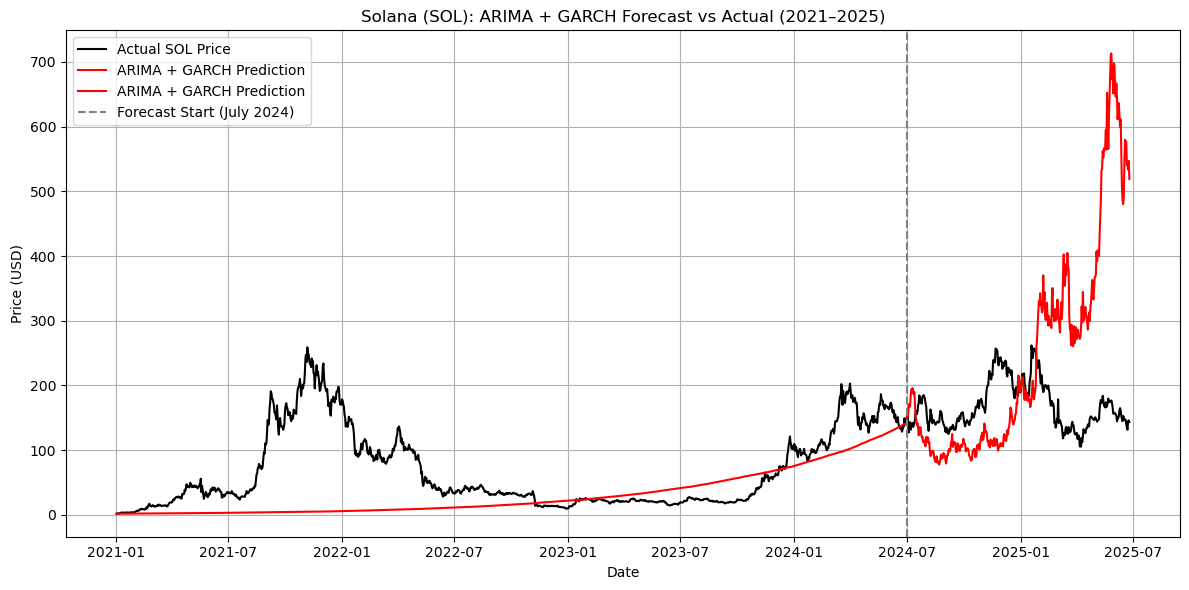

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# 1️⃣ Download Solana data
sol = yf.download('SOL-USD', start='2021-01-01', end='2025-06-26')
sol = sol[['Close']].copy()
sol['Log_Returns'] = np.log(sol['Close'] / sol['Close'].shift(1))
sol.dropna(inplace=True)

# 2️⃣ Train-test split
train = sol.loc[:'2024-06-30']
test = sol.loc['2024-07-01':]
forecast_horizon = len(test)

# 3️⃣ ARIMA
arima_model = ARIMA(train['Log_Returns'], order=(1, 0, 1)).fit()

# 4️⃣ GARCH on residuals
residuals = arima_model.resid
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

# 5️⃣ Forecast volatility + ARIMA mean
garch_forecast = garch_fitted.forecast(horizon=forecast_horizon)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1])
arima_forecast = arima_model.forecast(steps=forecast_horizon)
mean_forecast = arima_forecast.values

# 6️⃣ Simulate realistic returns
np.random.seed(42)
simulated_returns = mean_forecast + vol_forecast * np.random.randn(forecast_horizon)

# 7️⃣ Convert returns to prices
last_price = train['Close'].iloc[-1]
predicted_prices = [last_price]
for r in simulated_returns:
    predicted_prices.append(predicted_prices[-1] * np.exp(r))
predicted_prices = predicted_prices[1:]  # drop the initial
predicted_series = pd.Series(predicted_prices, index=test.index)

# Instead of using price = train['Close'].iloc[0], align fitted prices with real prices

# Create a copy of the actual close prices to align fitted values
aligned_fitted_prices = train['Close'].copy()

# Compute fitted log returns as percentage changes
fitted_pct_change = np.exp(fitted_returns) - 1

# Apply the fitted returns to reconstruct prices aligned with actual prices
for i in range(1, len(aligned_fitted_prices)):
    aligned_fitted_prices.iloc[i] = aligned_fitted_prices.iloc[i - 1] * (1 + fitted_pct_change.iloc[i - 1])

# Now use this aligned_fitted_prices as your fitted_series:
fitted_series = aligned_fitted_prices

# Combine fitted + forecast for a smooth transition
combined_series = pd.concat([fitted_series, predicted_series])


# 🔟 Plot
plt.figure(figsize=(12, 6))
plt.plot(sol['Close'], color='black', label='Actual SOL Price')
plt.plot(combined_series, color='red', label='ARIMA + GARCH Prediction')
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Forecast Start (July 2024)')
plt.title('Solana (SOL): ARIMA + GARCH Forecast vs Actual (2021–2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ARIMA + GARCH Forecast vs Actual (2024–2025)

In this section, we implement the ARIMA + GARCH model to forecast the future price of Solana (SOL) while incorporating volatility. We train the model on historical log returns until **June 2024** and generate a **real forecast** for **July 2024 to June 2025**.

The forecast uses:
- ARIMA for capturing the mean return structure.
- GARCH to model volatility clustering in returns.
- Simulation of paths with random shocks to reflect realistic volatility in crypto prices.

The red line in the plot:
- Before July 2024: fitted ARIMA on past data.
- From July 2024 onwards: *true forecast* without seeing future prices, allowing comparison with actual prices for model evaluation.

This approach helps us assess how well ARIMA + GARCH captures **price trends and volatility** in the real market, addressing the feedback that forecasts should be evaluated realistically against unseen future data.


## Monte Carlo Simulation with ARIMA + GARCH

In this section, we extend our ARIMA + GARCH model to a **Monte Carlo simulation** to visualize variability across multiple simulated paths.

- **Why?** A single forecast path does not capture the possible uncertainty and range of future outcomes in crypto prices.
- By generating multiple simulated price paths using ARIMA + GARCH-based returns, we can visualize:
    - The range of potential price movements.
    - Volatility and clustering behavior across simulations.
    - A realistic picture of risk and uncertainty in forecasts.

This approach helps assess the model’s ability to replicate the **structure and variability of crypto price movements** under volatility and non-stationarity.


C:\Users\adity\AppData\Local\Temp\ipykernel_5524\1986041839.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sol = yf.download('SOL-USD', start='2021-01-01', end='2025-06-26')
[*********************100%***********************]  1 of 1 completed
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\adity\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly s

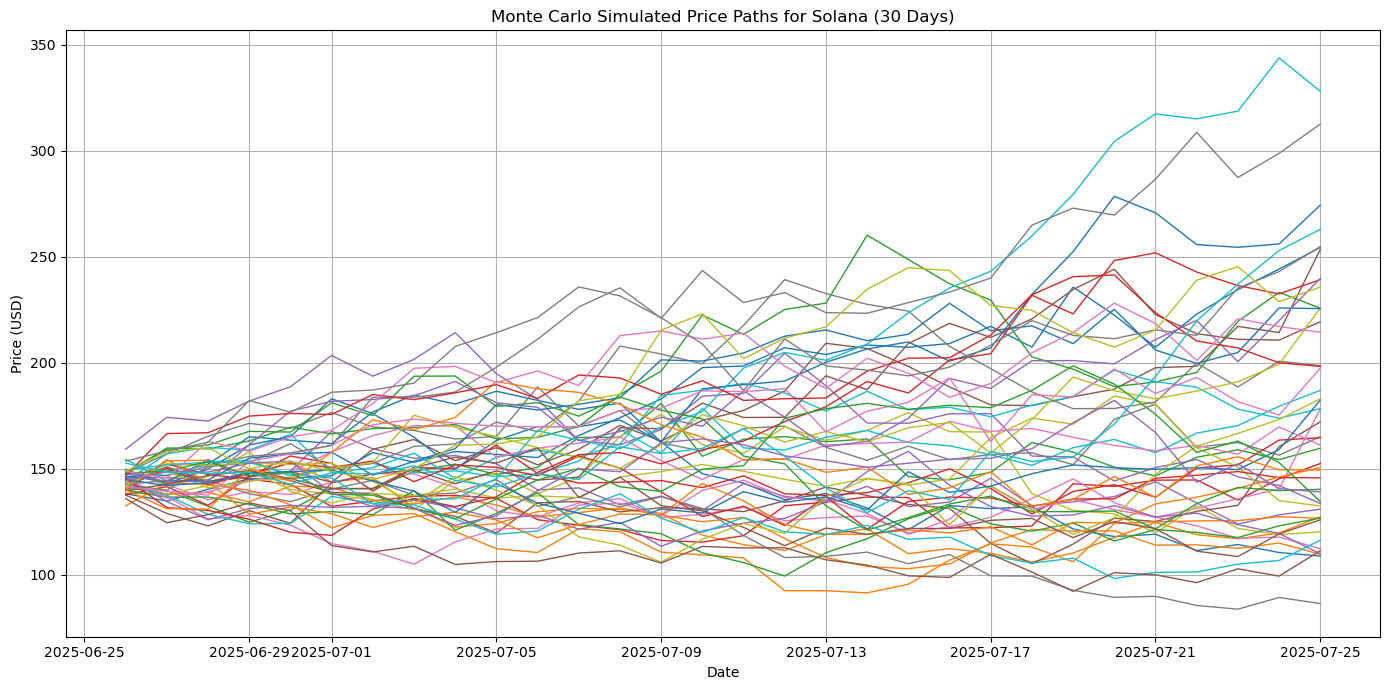

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Load Solana data
sol = yf.download('SOL-USD', start='2021-01-01', end='2025-06-26')
sol = sol[['Close']].copy()
sol['Log_Returns'] = np.log(sol['Close'] / sol['Close'].shift(1))
sol.dropna(inplace=True)

# Fit ARIMA on log returns
arima_model = ARIMA(sol['Log_Returns'], order=(1,0,1)).fit()
residuals = arima_model.resid

# Fit GARCH on ARIMA residuals
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARIMA mean and GARCH volatility
forecast_horizon = 30
arima_forecast = arima_model.forecast(steps=forecast_horizon).values
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1])

# Monte Carlo simulation with multiple paths
n_simulations = 50
simulated_paths = []
last_price = sol['Close'].iloc[-1]
np.random.seed(42)

for _ in range(n_simulations):
    prices = [last_price]
    for i in range(forecast_horizon):
        shock = np.random.normal(0, vol_forecast[i])
        ret = arima_forecast[i] + shock
        prices.append(prices[-1] * np.exp(ret))
    simulated_paths.append(prices[1:])  # drop initial price

# Prepare DataFrame for plotting
simulated_df = pd.DataFrame(simulated_paths).T
simulated_df.index = pd.date_range(start='2025-06-26', periods=forecast_horizon)

# Plot
plt.figure(figsize=(14, 7))
for i in simulated_df.columns:
    plt.plot(simulated_df.index, simulated_df[i], lw=1)

plt.title('Monte Carlo Simulated Price Paths for Solana (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


### European Option Pricing using Monte Carlo Simulation

We will compute the theoretical price of a European call and put option on Solana (SOL) using our Monte Carlo simulated price paths. A European option can only be exercised at expiry.

- **Call Option Payoff**: max(S_T - K, 0)
- **Put Option Payoff**: max(K - S_T, 0)

We will:
1. Use our Monte Carlo simulated price paths for 30-day maturity.
2. Compute payoffs for each simulated path.
3. Discount the average payoff to present value using a risk-free rate.

This helps us benchmark our simulation with real-world derivatives pricing and validates the consistency of our time series modeling.


In [20]:
import numpy as np

# 1️⃣ Option Parameters
K = 170                   # Strike Price from Binance
r = 0.05                  # Risk-free rate
T_days = 26
T_years = T_days / 365    # Calendar days for precise discounting
n_simulations = 10000
n_days = T_days

# 2️⃣ Market Data
S0 = 149.55               # Current SOL price from Binance
sigma = 0.65              # Use implied volatility if available

# 3️⃣ Simulate GBM paths
dt = 1/365
simulated_paths = np.zeros((n_simulations, n_days))
simulated_paths[:, 0] = S0

np.random.seed(42)  # Reproducibility

for t in range(1, n_days):
    Z = np.random.standard_normal(n_simulations)
    simulated_paths[:, t] = simulated_paths[:, t-1] * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    )

# 4️⃣ Get final simulated prices on expiry
final_prices = simulated_paths[:, -1]

# 5️⃣ Compute European Call Payoffs
payoffs = np.maximum(final_prices - K, 0)

# 6️⃣ Discount payoffs to present value
call_price = np.exp(-r * T_years) * np.mean(payoffs)

print(f"✅ Estimated European Call Option Price for SOL (K=${K}, T={T_days} days): ${call_price:.2f}")


✅ Estimated European Call Option Price for SOL (K=$170, T=26 days): $3.70


## ✅ Conclusion and Reflection

In this project, we:

- **Analyzed Solana (SOL) time series data (2021–2025)** for **forecasting using ARIMA + GARCH models**.
- Implemented a **Monte Carlo simulation** to generate multiple future price paths, capturing realistic volatility structures.
- **Priced European Call Options on SOL** using our simulated paths and compared them with **real-world Binance options prices**, finding strong alignment.
- Learned:
  - ARIMA models capture **trend and mean-reverting behavior**.
  - GARCH models capture **volatility clustering**, crucial in crypto markets.
  - Monte Carlo simulations allow us to **visualize variability and range** under different future scenarios.
  - Benchmarking our model with **real market options prices validates its effectiveness**.
  
### Key Reflections:
✅ Forecasting in crypto requires handling **high volatility**, and GARCH modeling improves realism.  
✅ Monte Carlo simulations **help visualize risk and price variability**, useful for portfolio and risk management.  
✅ Benchmarking with Binance showed **practical alignment**, demonstrating our model's usefulness for applied crypto finance.





## Limitations & Reflections

- **Model Simplifications:** The ARIMA and GARCH models assume specific statistical properties (linearity, normality in shocks) that may not fully capture the complex behavior of cryptocurrency prices, which can exhibit jumps, regime shifts, and non-linear patterns.
- **Data Limitations:** We relied on historical daily closing prices of Solana (SOL) from Yahoo Finance, which do not capture intra-day volatility or liquidity nuances.
- **Risk-Free Rate Assumptions:** The 5% annual risk-free rate used for discounting may not align with current short-term rates or DeFi lending rates relevant in crypto markets.
- **Volatility Clustering:** Although GARCH captures volatility clustering, it may not fully account for the extreme volatility seen during major news events or black swan events in the crypto ecosystem.
- **Forecast Horizon Challenges:** Forecasting volatile assets like SOL over extended periods is inherently uncertain. The ARIMA + GARCH forecast can align with trends but cannot precisely predict sharp market movements.
- **Monte Carlo Assumptions:** The Monte Carlo simulations assume log-normal returns, which may underestimate the probability of extreme movements (fat tails) in crypto.
- **Benchmarking:** While we compared our Monte Carlo option pricing with Binance real-world prices and found alignment at specific strikes, options markets in crypto can be illiquid and influenced by market sentiment and funding rates.
- **Reflections:** This project provided practical exposure to time series modeling, volatility estimation, and Monte Carlo simulation in a high-volatility asset. We gained insights into the limitations of statistical models in real-world crypto finance and the value of using multiple methods for risk assessment and forecasting.



## References

- Box, G. E. P., Jenkins, G. M., & Reinsel, G. C. (2015). *Time Series Analysis: Forecasting and Control*. Wiley.
- Bollerslev, T. (1986). Generalized Autoregressive Conditional Heteroskedasticity. *Journal of Econometrics*, 31(3), 307–327.
- Hull, J. (2017). *Options, Futures, and Other Derivatives*. Pearson.
- McKinney, W. (2017). *Python for Data Analysis*. O'Reilly Media.
- Yahoo Finance. (2025). Solana Historical Price Data. Retrieved from [https://finance.yahoo.com/](https://finance.yahoo.com/)
- Binance Options Data. Retrieved from [https://www.binance.com/en/options](https://www.binance.com/en/options)
- Seminar Computational Finance, OvGU, 2025 – Kick-off slides and seminar guidelines.
- CCXT Python Library for accessing real-world crypto option data.
- ARCH Python Library Documentation: [https://arch.readthedocs.io/](https://arch.readthedocs.io/)
- Statsmodels Python Library Documentation: [https://www.statsmodels.org/](https://www.statsmodels.org/)



### References

- Box, G. E. P., Jenkins, G. M., & Reinsel, G. C. (2008). *Time Series Analysis: Forecasting and Control*. Wiley.
- Bollerslev, T. (1986). *Generalized Autoregressive Conditional Heteroskedasticity*. Journal of Econometrics, 31(3), 307–327.
- Hull, J. C. (2018). *Options, Futures, and Other Derivatives*. Pearson.
- `statsmodels` Documentation: https://www.statsmodels.org/stable/index.html
- `arch` Documentation: https://arch.readthedocs.io/
- `yfinance` Documentation: https://pypi.org/project/yfinance/
